## Music Generation with a mini wavenet
Wavenet reads raw audio and generates music. For a micro experiment with limited data, we can reduce the difficulty of the training task by directly sampling the notes of the music directly to simplify the problem. 

In [1]:
import os

while 'notebook' in os.getcwd():
    os.chdir('..')

### 1. Read data
Data is retrieved from: http://www.piano-midi.de/schub.html  
The midi files are read and saved as a numpy array of the notes.  

Warning: the cell below may take a while. Instead, you can read the numpy array directly. 

In [25]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from music21 import converter, instrument, note, chord, stream, corpus, midi

#defining function to read MIDI files
def read_midi(file, verbose=False):
    
    if verbose: print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #note
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                #chord
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

#specify the path
path='schubert/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

with open('notes_array.npy', 'wb') as f:
    np.save(f, notes_array)
    
# with open('notes_array.npy', 'wb') as f:
#     notes_array = np.load(f)

display(notes_array[0])

array(['D5', 'B-2', 'D4', ..., '5.10', '10.2.5', '5.10'], dtype='<U8')

### 2. EDA: what do the unique notes look like?
There seems to be a "power law" with the notes, that is, a small number of notes dominate the songs. 

345


(array([221.,  40.,  31.,  13.,   8.,   3.,   7.,   9.,   7.,   6.]),
 array([1.0000e+00, 1.6170e+02, 3.2240e+02, 4.8310e+02, 6.4380e+02,
        8.0450e+02, 9.6520e+02, 1.1259e+03, 1.2866e+03, 1.4473e+03,
        1.6080e+03]),
 <BarContainer object of 10 artists>)

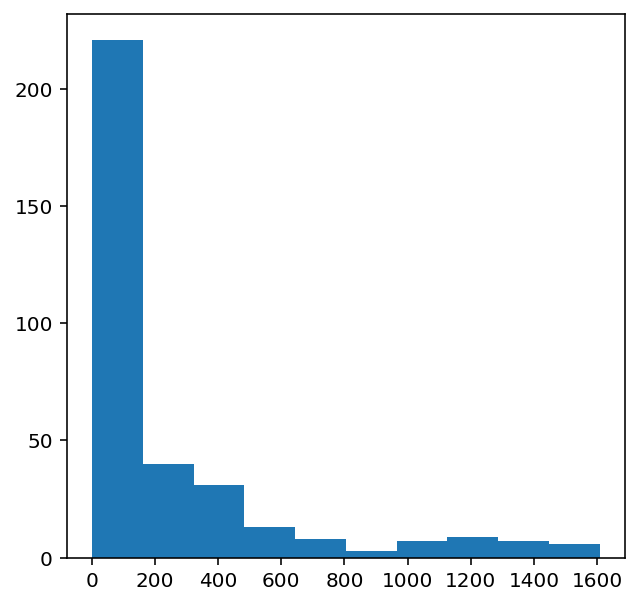

In [4]:
#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]
unique_notes = list(set(notes_))
print(len(unique_notes))

#computing frequency of each note
freq = dict(Counter(notes_))
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))
plt.hist(no)

### 3. Preparing data
To make our training task easier:
1. Keep the most frequent notes. This will remove uncommon notes. 
2. Break into pairs of input and output notes as X and Y for training.
3. assign integer to each note. This is similar to tokenization for NLP. 
4. Split data into train and test set for experimentation.

In [21]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(f"{len(frequent_notes)} frequent notes found")

new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

182 frequent notes found


/home/jeremy/anaconda3/envs/wavenet/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [10]:
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [11]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [12]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

### 4. Define model
Define wavenet.  
One key difference in the model is that residual connections are removed, because the training data is so small anyway - we should be able to reach convergence quite soon. 

In [44]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

2021-10-21 21:01:16.733867: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-21 21:01:16.733896: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           18200     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            19264     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

2021-10-21 21:01:17.559956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-21 21:01:17.560454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-21 21:01:17.561088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-21 21:01:17.561148: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-10-21 21:01:17.561195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not lo

In [45]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])


2021-10-21 21:01:25.255624: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
492/492 [==============================] - 9s 17ms/step - loss: 4.3593 - val_loss: 4.1586

Epoch 00001: val_loss improved from inf to 4.15864, saving model to best_model.h5
Epoch 2/50
492/492 [==============================] - 9s 18ms/step - loss: 3.8802 - val_loss: 3.9260

Epoch 00002: val_loss improved from 4.15864 to 3.92598, saving model to best_model.h5
Epoch 3/50
492/492 [==============================] - 8s 16ms/step - loss: 3.7052 - val_loss: 3.7704

Epoch 00003: val_loss improved from 3.92598 to 3.77042, saving model to best_model.h5
Epoch 4/50
492/492 [==============================] - 9s 18ms/step - loss: 3.5789 - val_loss: 3.7276

Epoch 00004: val_loss improved from 3.77042 to 3.72757, saving model to best_model.h5
Epoch 5/50
492/492 [==============================] - 8s 17ms/step - loss: 3.4891 - val_loss: 3.6268

Epoch 00005: val_loss improved from 3.72757 to 3.62685, saving model to best_model.h5
Epoch 6/50
492/492 [==============================] - 9s 17ms/st

492/492 [==============================] - 8s 17ms/step - loss: 2.6136 - val_loss: 3.1379

Epoch 00047: val_loss improved from 3.14586 to 3.13794, saving model to best_model.h5
Epoch 48/50
492/492 [==============================] - 8s 17ms/step - loss: 2.6100 - val_loss: 3.1412

Epoch 00048: val_loss did not improve from 3.13794
Epoch 49/50
492/492 [==============================] - 9s 18ms/step - loss: 2.6033 - val_loss: 3.1507

Epoch 00049: val_loss did not improve from 3.13794
Epoch 50/50
492/492 [==============================] - 9s 19ms/step - loss: 2.6037 - val_loss: 3.1302

Epoch 00050: val_loss improved from 3.13794 to 3.13016, saving model to best_model.h5


### 5. Infer from best model
Run best model on a random song from the validation set and play 10 timesteps from the song. 

In [8]:
#loading best model
from keras.models import load_model
model = load_model('best_model.h5')

2021-10-22 00:30:34.786163: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-22 00:30:34.786251: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-22 00:30:37.312779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 00:30:37.313534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 00:30:37.314368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: 

In [20]:
import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]
    
print(predictions)
print(predicted_notes)

[29, 129, 46, 46, 46, 46, 46, 46, 58, 149]
['G1', 'F2', '7.9.1', '7.9.1', '7.9.1', '7.9.1', '7.9.1', '7.9.1', '3.4', 'C3']


In [19]:
def convert_to_midi(prediction_output):
    """
    Return output notes to play on notebook
    """
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')
    
    return output_notes

output_notes = convert_to_midi(predicted_notes)
display(output_notes)
stream.Stream(output_notes).show('midi')

[<music21.chord.Chord F# B->,
 <music21.note.Note E>,
 <music21.note.Note E>,
 <music21.note.Note E>,
 <music21.chord.Chord F# B->,
 <music21.chord.Chord F A>,
 <music21.chord.Chord F# B->,
 <music21.chord.Chord F A>,
 <music21.note.Note G>,
 <music21.chord.Chord F A>]